#  What is BERT?
* BERT stands for Bidirectional Encoders Representations from Transformers.
* Bidirectional - to understand the text you’re looking you’ll have to look back (at the previous words) and forward (at the next words)
* Transformers - The Attention Is All You Need paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. his in a sentence refers to Jim).
* (Pre-trained) contextualized word embeddings - The ELMO paper introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

In this notebook we will be using transformers library by hugging face.

In [1]:
import numpy as np
import pandas as pd

import os

for dirname, _, filenames in os.walk('C:\\Users\\RAJAS BHARAMBE\\Desktop\\Machine Learning\\Projects_ML\\tweets-sentiment-analysis-using-bert-master'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\RAJAS BHARAMBE\Desktop\Machine Learning\Projects_ML\tweets-sentiment-analysis-using-bert-master\README.md
C:\Users\RAJAS BHARAMBE\Desktop\Machine Learning\Projects_ML\tweets-sentiment-analysis-using-bert-master\sentiment-analysis-using-bert.ipynb
C:\Users\RAJAS BHARAMBE\Desktop\Machine Learning\Projects_ML\tweets-sentiment-analysis-using-bert-master\smile-annotations-final.csv
C:\Users\RAJAS BHARAMBE\Desktop\Machine Learning\Projects_ML\tweets-sentiment-analysis-using-bert-master\.git\config
C:\Users\RAJAS BHARAMBE\Desktop\Machine Learning\Projects_ML\tweets-sentiment-analysis-using-bert-master\.git\description
C:\Users\RAJAS BHARAMBE\Desktop\Machine Learning\Projects_ML\tweets-sentiment-analysis-using-bert-master\.git\FETCH_HEAD
C:\Users\RAJAS BHARAMBE\Desktop\Machine Learning\Projects_ML\tweets-sentiment-analysis-using-bert-master\.git\HEAD
C:\Users\RAJAS BHARAMBE\Desktop\Machine Learning\Projects_ML\tweets-sentiment-analysis-using-bert-master\.git\hooks\applypatch-msg.sampl

In [5]:
import torch
from tqdm.notebook import tqdm

Reading SMILE twitter emotion dataset

In [6]:
df = pd.read_csv("C:\\Users\\RAJAS BHARAMBE\\Desktop\\Machine Learning\\Projects_ML\\tweets-sentiment-analysis-using-bert-master\\smile-annotations-final.csv",
                names = ['Id','Text','Category'])
df.set_index('Id',inplace = True)
df[:4]

,Text,Category
Id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy


In [7]:
df.Text.iloc[0]

'@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap'

* Counts of Emotions in the dataset

In [8]:
df.Category.value_counts()

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: Category, dtype: int64

We will be filtering the emotions with single emotions and ignoring the rest.

In [9]:
df = df[(df.Category!="nocode")]
df = df[~(df.Category.str.contains("\|"))]
df.Category.value_counts()

happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: Category, dtype: int64

In [10]:
possible_label = df.Category.unique()
dict_label = {}
for index,possible_label in enumerate(possible_label):
    dict_label[possible_label] = index
dict_label

{'happy': 0,
 'not-relevant': 1,
 'angry': 2,
 'disgust': 3,
 'sad': 4,
 'surprise': 5}

In [11]:
df["Label"] = df["Category"].replace(dict_label)
df.head()

,Text,Category,Label
Id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0


C:\Users\RAJAS BHARAMBE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


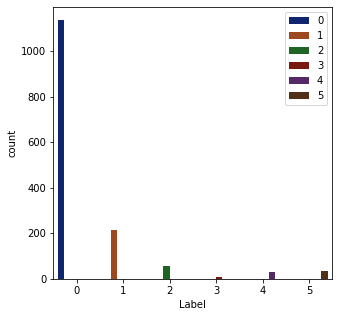

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (5,5)
sns.countplot(df["Label"],hue = df["Label"],palette = 'dark')
plt.legend(loc = 'upper right')
plt.show()

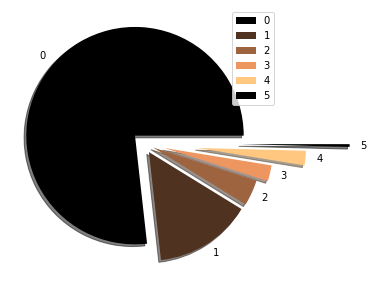

In [13]:
labels = [0,1,2,3,4,5]
sizes = df["Label"].value_counts()
colors = plt.cm.copper(np.linspace(0, 1, 5))
explode = [0.1, 0.1,0.1, 0.2, 0.5, 0.9]
cmap = plt.get_cmap('Spectral')
plt.pie(sizes,labels = labels,colors = colors,shadow = True,explode = explode)
plt.legend()
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df.index.values,
                                                df.Label.values,
                                                test_size = 0.15,
                                                random_state=17,
                                                stratify = df.Label.values)

In [14]:
 df

,Text,Category,Label
Id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0
...,...,...,...
611258135270060033,@_TheWhitechapel @Campaignforwool @SlowTextile...,not-relevant,1
612214539468279808,“@britishmuseum: Thanks for ranking us #1 in @...,happy,0
613678555935973376,MT @AliHaggett: Looking forward to our public ...,happy,0


In [13]:
df.loc[X_train,'data_type'] = 'train'
df.loc[X_test,'data_type'] = 'test'

In [14]:
df.head()

,Text,Category,Label,data_type
Id,,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0,train
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0,train
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0,train
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0,train
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0,train


In [15]:
df.groupby(['Category','Label','data_type']).count()

Text
Category     Label data_type      
angry        2     test          9
                   train        48
disgust      3     test          1
                   train         5
happy        0     test        171
                   train       966
not-relevant 1     test         32
                   train       182
sad          4     test          5
                   train        27
surprise     5     test          5
                   train        30

# Modeling

In [16]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

Encoding text using BERT Tokenizer


In [18]:
encoder_train = tokenizer.batch_encode_plus(df[df["data_type"]=='train'].Text.values,
                                           add_special_tokens = True,
                                            return_attention_masks = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')



encoder_test = tokenizer.batch_encode_plus(df[df["data_type"]=='test'].Text.values,
                                           add_special_tokens = True,
                                            return_attention_masks = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')

input_ids_train = encoder_train['input_ids']
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(df[df['data_type']=='train'].Label.values)


input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(df[df['data_type']=='test'].Label.values)

In [19]:
data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
data_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)


In [20]:
len(data_train),len(data_test)

(1258, 223)

* We will use sequence classification model as we have to classify multi label text from the dataset.

In [21]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                     num_labels = len(dict_label),
                                     output_attentions = False,
                                     output_hidden_states =  False)

In [22]:
from torch.utils.data import RandomSampler,SequentialSampler,DataLoader

dataloader_train = DataLoader(
    data_train,
    sampler= RandomSampler(data_train),
    batch_size = 16
    
)


dataloader_test = DataLoader(
    data_test,
    sampler= RandomSampler(data_test),
    batch_size = 32
    
)

In [23]:
from transformers import AdamW,get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),lr = 1e-5,eps = 1e-8)

epochs  = 10
scheduler = get_linear_schedule_with_warmup(
            optimizer,
    num_warmup_steps = 0,
   num_training_steps = len(dataloader_train)*epochs 
)

Defining Model metrics

In [15]:
from sklearn.metrics import f1_score 

def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat,average = 'weighted')


In [25]:
def accuracy_per_class(preds,labels):
    label_dict_reverse = {v:k for k,v in dict_label.items()}
    
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f"Class:{label_dict_reverse}")
        print(f"Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n")

In [26]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Loading:{device}")

cuda


Defining Evaluation

In [28]:
def evaluate(dataloader_val):
    model.eval()
    
    loss_val_total = 0
    predictions,true_vals = [],[]
    
    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
        
    loss_val_avg = loss_val_total/len(dataloader_val)  
    
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0) 
    return loss_val_avg,predictions,true_vals
            

* Training Data

In [29]:
for epoch in tqdm(range(1,epochs+1)):
    model.train()
    
    loss_train_total=0
    
    progress_bar = tqdm(dataloader_train,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)
    
    
    for batch in progress_bar:
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            "input_ids":batch[0],
            "attention_mask":batch[1],
            "labels":batch[2]
            
        }
        outputs = model(**inputs)
        
        loss = outputs[0]
#         logits = outputs[1]
        loss_train_total +=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        
        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})

    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training Loss: {loss_train_avg}')
    val_loss,predictions,true_vals = evaluate(dataloader_test)
    test_score = f1_score_func(predictions,true_vals)
    tqdm.write(f'Val Loss:{val_loss}\n Test Score:{test_score}')
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.9699796487258959



Val Loss:0.7014265102999551
 Test Score:0.6953185953656175



Epoch {epoch}
Training Loss: 0.6117297460006762



Val Loss:0.5799521633556911
 Test Score:0.7571476303525896



Epoch {epoch}
Training Loss: 0.4657496551546869



Val Loss:0.5237005438123431
 Test Score:0.7902172903312981



Epoch {epoch}
Training Loss: 0.38381981491288053



Val Loss:0.5376968894686017
 Test Score:0.7938675400685126



Epoch {epoch}
Training Loss: 0.3033778618408155



Val Loss:0.5278307454926627
 Test Score:0.8050975582150716



Epoch {epoch}
Training Loss: 0.24704220919292183



Val Loss:0.5274006170885903
 Test Score:0.8433260525207777



Epoch {epoch}
Training Loss: 0.21461329679889016



Val Loss:0.5721525656325477
 Test Score:0.8528528996575542



Epoch {epoch}
Training Loss: 0.1806286097138743



Val Loss:0.5534958051783698
 Test Score:0.8494232891614654



Epoch {epoch}
Training Loss: 0.15728285135347633



Val Loss:0.5554194450378418
 Test Score:0.8469984025469383



Epoch {epoch}
Training Loss: 0.1455424027163771



Val Loss:0.5662243110792977
 Test Score:0.8505631660263822



# Using the saved model

In [31]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
_,predictions,true_vals = evaluate(dataloader_test)

In [ ]:
accuracy_per_class(predictions,true_vals)